## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

## Getting Data Ready

In [2]:
import pandas as pd

dataset = pd.read_csv("Housing_dataset_train.csv")
test = pd.read_csv("Housing_dataset_test.csv")
sub = pd.read_csv("Sample_submission.csv")

## A look at the top five rows using the DataFrame’s head() method

In [3]:
dataset.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [4]:
test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [5]:
sub.head()

,ID
0,845
1,1924
2,10718
3,12076
4,12254


## A quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values¶

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


There are 14,000 instances in the train dataset. Notice that the loc, title, bedroom, bathroon and parking space doesn't have up to 14,000 entries, meaning that some districts are missing this feature.

All attributes are numerical, except the loc and title attributes. Its type is object and I know that it must be a text attribute. I find out what categories exist and how many districts belong to each category by using the value_counts() method:

In [7]:
dataset["loc"].value_counts()

Kaduna         370
Anambra        363
Benue          355
Yobe           353
Borno          351
Kano           351
Nasarawa       349
Cross River    349
Zamfara        348
Imo            348
Ebonyi         346
Kebbi          346
Katsina        345
Ogun           345
Ondo           344
Gombe          343
Bauchi         342
Oyo            341
Adamawa        341
Bayelsa        340
Plateau        338
Osun           338
Jigawa         337
Ekiti          336
Kwara          333
Niger          330
Akwa Ibom      329
Lagos          328
Sokoto         326
Delta          325
Enugu          324
Rivers         323
Kogi           321
Taraba         315
Abia           312
Edo            302
Name: loc, dtype: int64

In [8]:
dataset["title"].value_counts()

Flat                    1372
Apartment               1331
Townhouse               1327
Mansion                 1322
Detached duplex         1312
Penthouse               1306
Semi-detached duplex    1299
Bungalow                1293
Terrace duplex          1266
Cottage                  450
Name: title, dtype: int64

## A summary of the numerical attributes

In [9]:
dataset.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


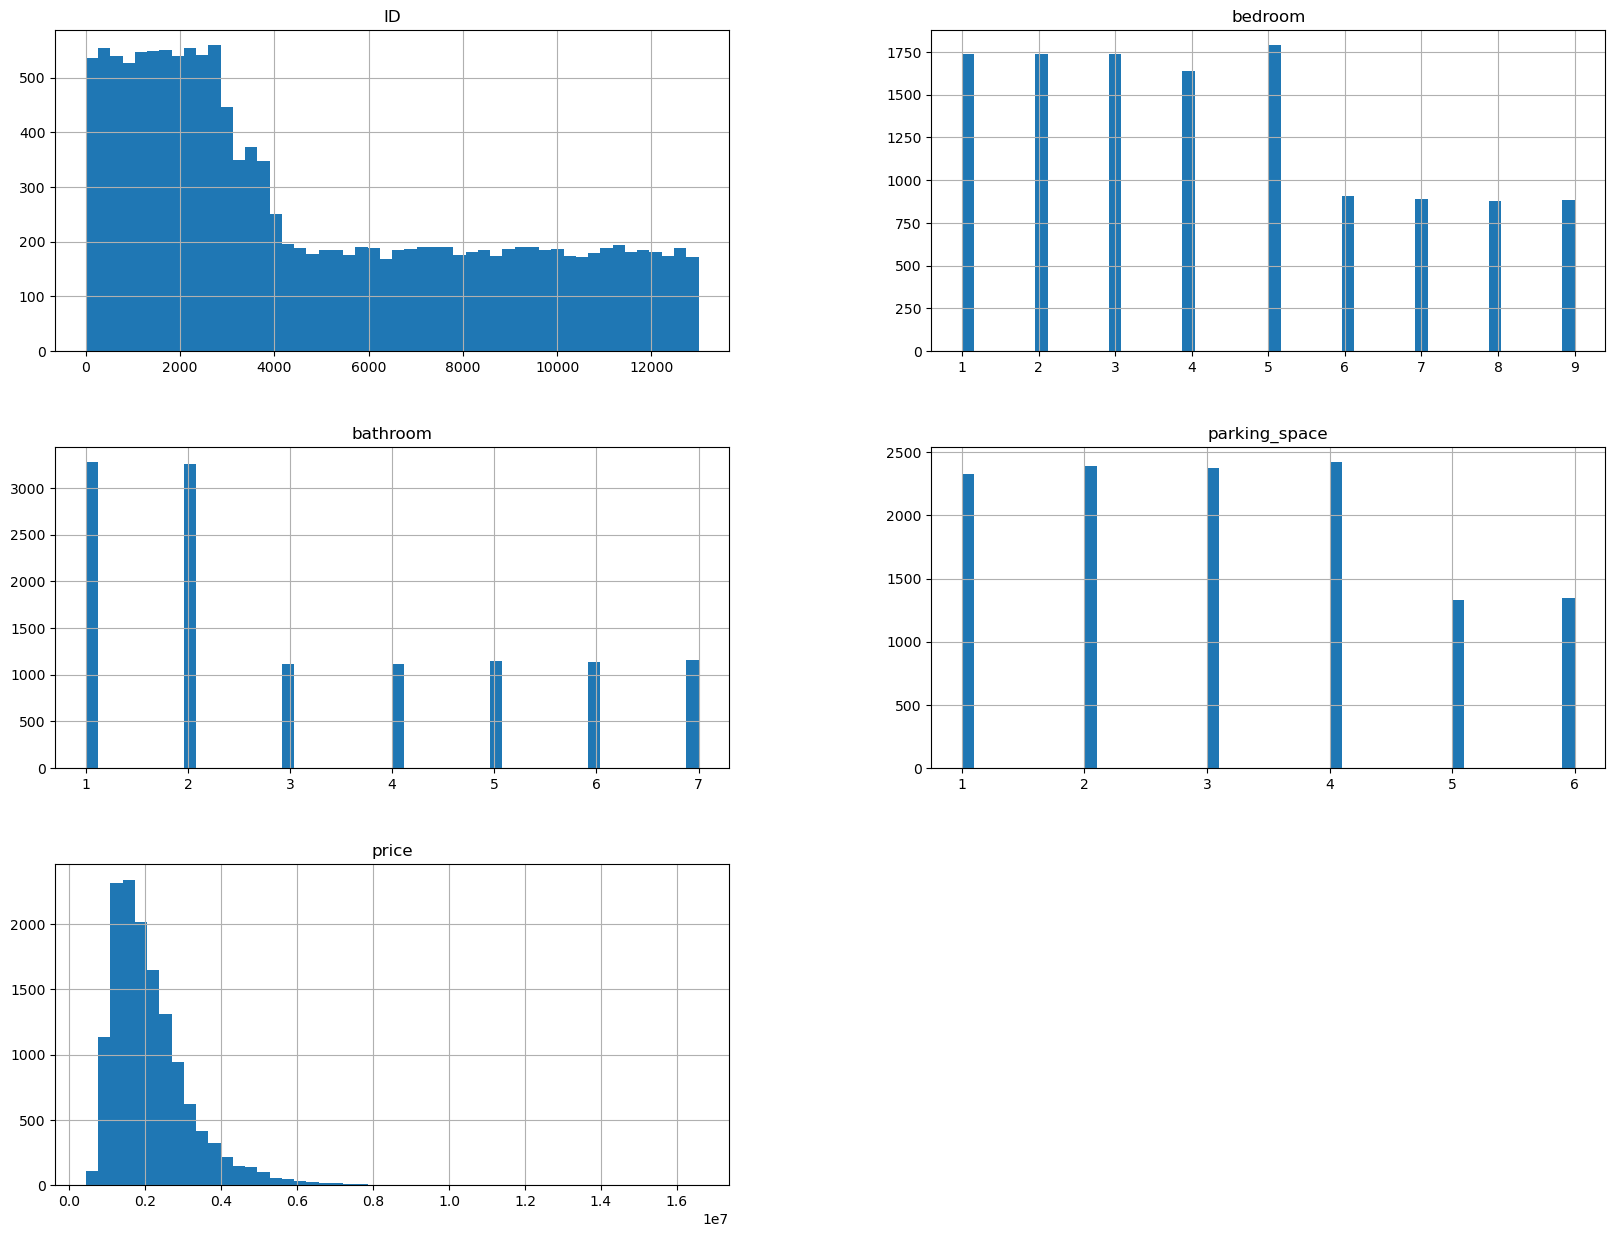

In [10]:
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20,15))
plt.show()

A histogram for each numerical attribute

## Handling Null Values in  Columns

In [11]:
# Deleting the row with missing(NAN) data
dataset.dropna(inplace=True)

In [12]:
# Checing if there is still missing data
dataset.isnull().sum()

ID               0
loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
price            0
dtype: int64

## Handling Text and Categorical Attributes
Earlier I left out the categorical attribute loc and area because it is a text
attribute so I cannot compute their summary of A numerical attribute. Most Machine Learning algorithms pre‐
fer to work with numbers anyway, so let’s convert these text labels to numbers.
Scikit-Learn provides a transformer for this task called LabelEncoder:

In [13]:
# Python code to convert categorical attribute to numerical attribute using LabelEncoder

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)       

In [14]:
dataset=MultiColumnLabelEncoder(columns = ['loc','title']).fit_transform(dataset)
dataset

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,19,7,2.0,2.0,1.0,1149999.565
3,2224,3,3,5.0,2.0,4.0,2410306.756
7,3003,19,6,3.0,3.0,5.0,2043107.592
10,12573,26,1,1.0,2.0,6.0,1330213.036
11,2624,5,0,3.0,4.0,2.0,1891772.069
...,...,...,...,...,...,...,...
13989,10107,20,8,4.0,7.0,2.0,1581061.171
13990,7174,20,6,8.0,7.0,3.0,3086400.032
13992,3423,26,2,1.0,2.0,2.0,1508351.845
13994,10477,33,3,8.0,1.0,6.0,2837199.086


In [15]:
test=MultiColumnLabelEncoder(columns = ['loc','title']).fit_transform(test)
test

,ID,loc,title,bedroom,bathroom,parking_space
0,845,18,6,4,1,2
1,1924,1,0,2,2,4
2,10718,1,1,2,7,2
3,12076,23,5,9,5,2
4,12254,14,7,5,6,1
...,...,...,...,...,...,...
5995,1594,12,4,4,5,2
5996,2416,1,8,5,7,1
5997,10195,29,9,4,1,4
5998,9455,4,4,3,7,5


A look at how much each attribute correlates with the median house value
The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that
there is a strong positive correlation and when the coefficient is close to –1, it means
that there is a strong negative correlation

In [16]:
corr_matrix = dataset.corr()
corr_matrix["price"].sort_values(ascending=False)

price            1.000000
bedroom          0.535665
bathroom         0.224481
ID               0.178304
title            0.161517
parking_space    0.119511
loc             -0.025580
Name: price, dtype: float64

## Discover and Visualize the Data to Gain Insights
A quick glance at the data to get a general understanding of
the kind of data I am manipulating. Now the goal is to go a little bit more in depth.


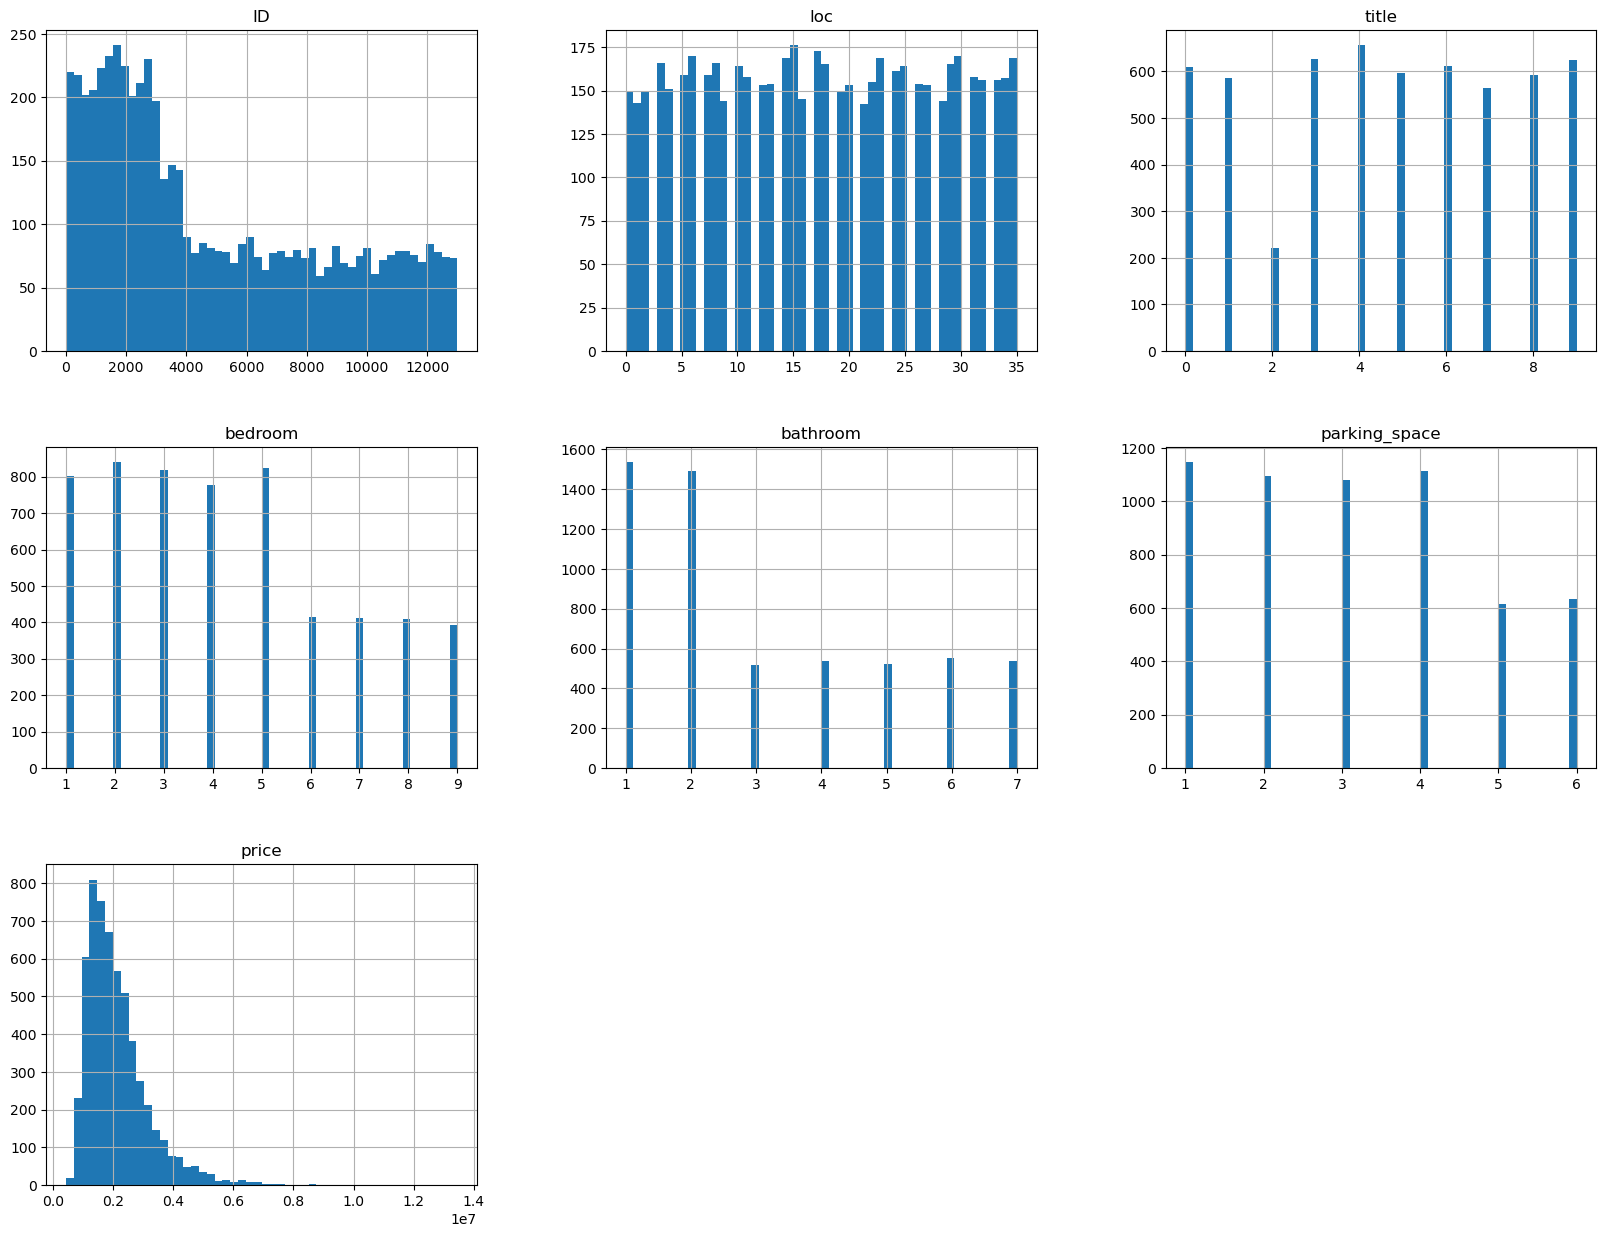

In [17]:
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20,15))
plt.show()

This image tells you that the housing prices are very much related to the bedroom attribute than the remaing attributes

In [18]:
# A look at the dataset again
dataset

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,19,7,2.0,2.0,1.0,1149999.565
3,2224,3,3,5.0,2.0,4.0,2410306.756
7,3003,19,6,3.0,3.0,5.0,2043107.592
10,12573,26,1,1.0,2.0,6.0,1330213.036
11,2624,5,0,3.0,4.0,2.0,1891772.069
...,...,...,...,...,...,...,...
13989,10107,20,8,4.0,7.0,2.0,1581061.171
13990,7174,20,6,8.0,7.0,3.0,3086400.032
13992,3423,26,2,1.0,2.0,2.0,1508351.845
13994,10477,33,3,8.0,1.0,6.0,2837199.086


## Select and Train a Model
I framed the problem, I have got the data, clean it and explored it. I
prepare the data for Machine Learning algorithms. I am now ready
to select and train a Machine Learning model

In [19]:
X=dataset.drop(["price"], axis=1)
y=dataset["price"]

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 X, y, random_state=0)

## CatBoostRegressor Model

In [21]:
from catboost import CatBoostRegressor
cat_reg = CatBoostRegressor()
cat_reg.fit(X_train, y_train)

car_predictions = cat_reg.predict(X_train)
cat_mse = mean_squared_error(y_train, car_predictions)
cat_rmse = np.sqrt(cat_mse)
cat_rmse

Learning rate set to 0.05149
0:	learn: 1033104.0529702	total: 217ms	remaining: 3m 37s
1:	learn: 1005441.3893496	total: 223ms	remaining: 1m 51s
2:	learn: 980685.2032098	total: 227ms	remaining: 1m 15s
3:	learn: 957244.8929173	total: 232ms	remaining: 57.8s
4:	learn: 935512.9318196	total: 237ms	remaining: 47.1s
5:	learn: 915263.0938040	total: 241ms	remaining: 40s
6:	learn: 894874.5293816	total: 246ms	remaining: 34.9s
7:	learn: 875267.0483249	total: 251ms	remaining: 31.1s
8:	learn: 857646.7106858	total: 255ms	remaining: 28.1s
9:	learn: 842233.5165558	total: 260ms	remaining: 25.7s
10:	learn: 831074.0678964	total: 264ms	remaining: 23.8s
11:	learn: 817747.3119175	total: 269ms	remaining: 22.1s
12:	learn: 804091.3807013	total: 273ms	remaining: 20.8s
13:	learn: 790918.1282684	total: 278ms	remaining: 19.6s
14:	learn: 776995.6666502	total: 283ms	remaining: 18.6s
15:	learn: 765633.0438027	total: 288ms	remaining: 17.7s
16:	learn: 755504.6345491	total: 292ms	remaining: 16.9s
17:	learn: 746047.3314967	

153:	learn: 397380.4426829	total: 973ms	remaining: 5.34s
154:	learn: 396665.5193060	total: 979ms	remaining: 5.34s
155:	learn: 396356.5549165	total: 985ms	remaining: 5.33s
156:	learn: 395948.2989698	total: 990ms	remaining: 5.31s
157:	learn: 395487.2679106	total: 995ms	remaining: 5.3s
158:	learn: 394200.0227577	total: 1000ms	remaining: 5.29s
159:	learn: 393696.8144264	total: 1s	remaining: 5.27s
160:	learn: 393143.2540795	total: 1.01s	remaining: 5.26s
161:	learn: 392589.9693826	total: 1.01s	remaining: 5.25s
162:	learn: 391315.8877827	total: 1.02s	remaining: 5.23s
163:	learn: 390957.6175869	total: 1.02s	remaining: 5.22s
164:	learn: 389444.3621147	total: 1.03s	remaining: 5.21s
165:	learn: 388684.9193663	total: 1.03s	remaining: 5.2s
166:	learn: 388377.9048906	total: 1.04s	remaining: 5.18s
167:	learn: 387547.4491736	total: 1.04s	remaining: 5.17s
168:	learn: 386701.4709403	total: 1.05s	remaining: 5.16s
169:	learn: 385902.5704532	total: 1.05s	remaining: 5.14s
170:	learn: 385739.2758743	total: 1

302:	learn: 322152.6702253	total: 1.73s	remaining: 3.97s
303:	learn: 321856.3709649	total: 1.73s	remaining: 3.97s
304:	learn: 321586.8758567	total: 1.74s	remaining: 3.96s
305:	learn: 321232.7129342	total: 1.75s	remaining: 3.96s
306:	learn: 320564.2740558	total: 1.75s	remaining: 3.95s
307:	learn: 320194.8106111	total: 1.76s	remaining: 3.95s
308:	learn: 319953.9078751	total: 1.76s	remaining: 3.94s
309:	learn: 319678.9675717	total: 1.77s	remaining: 3.94s
310:	learn: 319146.7172759	total: 1.77s	remaining: 3.93s
311:	learn: 318610.4453185	total: 1.78s	remaining: 3.92s
312:	learn: 318352.9847829	total: 1.78s	remaining: 3.92s
313:	learn: 318163.2649853	total: 1.79s	remaining: 3.91s
314:	learn: 317722.2583834	total: 1.79s	remaining: 3.9s
315:	learn: 317420.5370921	total: 1.8s	remaining: 3.9s
316:	learn: 317200.2709175	total: 1.8s	remaining: 3.89s
317:	learn: 316881.1509756	total: 1.81s	remaining: 3.88s
318:	learn: 316594.2606088	total: 1.81s	remaining: 3.88s
319:	learn: 316111.0566632	total: 1

447:	learn: 285320.5046752	total: 2.44s	remaining: 3s
448:	learn: 284995.1503294	total: 2.44s	remaining: 3s
449:	learn: 284744.4185968	total: 2.45s	remaining: 2.99s
450:	learn: 284598.3011661	total: 2.45s	remaining: 2.99s
451:	learn: 284418.5609574	total: 2.46s	remaining: 2.98s
452:	learn: 284253.6840449	total: 2.46s	remaining: 2.97s
453:	learn: 284115.0201843	total: 2.47s	remaining: 2.97s
454:	learn: 283987.2461967	total: 2.47s	remaining: 2.96s
455:	learn: 283874.7581822	total: 2.48s	remaining: 2.96s
456:	learn: 283720.7569534	total: 2.48s	remaining: 2.95s
457:	learn: 283257.2257874	total: 2.49s	remaining: 2.94s
458:	learn: 283098.6617347	total: 2.49s	remaining: 2.94s
459:	learn: 282992.7167007	total: 2.5s	remaining: 2.94s
460:	learn: 282797.6810158	total: 2.5s	remaining: 2.93s
461:	learn: 282697.0639788	total: 2.51s	remaining: 2.92s
462:	learn: 282317.1091520	total: 2.52s	remaining: 2.92s
463:	learn: 282162.7767826	total: 2.52s	remaining: 2.91s
464:	learn: 282043.3618608	total: 2.52s

592:	learn: 260177.1789004	total: 3.21s	remaining: 2.2s
593:	learn: 260053.3437855	total: 3.21s	remaining: 2.2s
594:	learn: 259641.9328510	total: 3.22s	remaining: 2.19s
595:	learn: 259556.7591402	total: 3.22s	remaining: 2.19s
596:	learn: 259421.5906877	total: 3.23s	remaining: 2.18s
597:	learn: 259350.1906989	total: 3.23s	remaining: 2.17s
598:	learn: 259079.8936836	total: 3.24s	remaining: 2.17s
599:	learn: 258606.0020260	total: 3.24s	remaining: 2.16s
600:	learn: 258484.7378722	total: 3.25s	remaining: 2.16s
601:	learn: 258375.0702603	total: 3.25s	remaining: 2.15s
602:	learn: 258277.6767913	total: 3.26s	remaining: 2.15s
603:	learn: 258220.2596252	total: 3.26s	remaining: 2.14s
604:	learn: 258111.9308611	total: 3.27s	remaining: 2.13s
605:	learn: 257944.9039832	total: 3.27s	remaining: 2.13s
606:	learn: 257877.4213166	total: 3.28s	remaining: 2.12s
607:	learn: 257660.5751514	total: 3.29s	remaining: 2.12s
608:	learn: 257587.7044375	total: 3.29s	remaining: 2.11s
609:	learn: 257387.0341015	total:

741:	learn: 239234.4219710	total: 4.2s	remaining: 1.46s
742:	learn: 239107.7336772	total: 4.2s	remaining: 1.45s
743:	learn: 239013.7797328	total: 4.21s	remaining: 1.45s
744:	learn: 238869.1450545	total: 4.21s	remaining: 1.44s
745:	learn: 238639.7090861	total: 4.21s	remaining: 1.44s
746:	learn: 238465.0898109	total: 4.22s	remaining: 1.43s
747:	learn: 238303.9603953	total: 4.23s	remaining: 1.42s
748:	learn: 238204.4971827	total: 4.24s	remaining: 1.42s
749:	learn: 238102.6337812	total: 4.24s	remaining: 1.41s
750:	learn: 238065.4462435	total: 4.25s	remaining: 1.41s
751:	learn: 237815.4840599	total: 4.25s	remaining: 1.4s
752:	learn: 237689.8139891	total: 4.26s	remaining: 1.4s
753:	learn: 237582.6582301	total: 4.26s	remaining: 1.39s
754:	learn: 237535.4928641	total: 4.27s	remaining: 1.39s
755:	learn: 237277.8878711	total: 4.27s	remaining: 1.38s
756:	learn: 237220.2100233	total: 4.28s	remaining: 1.37s
757:	learn: 237155.1537508	total: 4.28s	remaining: 1.37s
758:	learn: 237061.1327989	total: 4

888:	learn: 221113.3072084	total: 4.97s	remaining: 620ms
889:	learn: 221054.4863866	total: 4.97s	remaining: 615ms
890:	learn: 220977.5909175	total: 4.98s	remaining: 609ms
891:	learn: 220739.8384445	total: 4.99s	remaining: 604ms
892:	learn: 220637.1385594	total: 4.99s	remaining: 598ms
893:	learn: 220509.3625476	total: 5s	remaining: 592ms
894:	learn: 220391.1820266	total: 5s	remaining: 587ms
895:	learn: 220261.0022215	total: 5.01s	remaining: 581ms
896:	learn: 220089.6114508	total: 5.01s	remaining: 575ms
897:	learn: 220030.3395048	total: 5.01s	remaining: 570ms
898:	learn: 219948.4263502	total: 5.02s	remaining: 564ms
899:	learn: 219832.8270961	total: 5.03s	remaining: 558ms
900:	learn: 219655.3001943	total: 5.03s	remaining: 553ms
901:	learn: 219520.1938596	total: 5.04s	remaining: 547ms
902:	learn: 219450.4419425	total: 5.04s	remaining: 541ms
903:	learn: 219392.6985893	total: 5.04s	remaining: 536ms
904:	learn: 219283.4875106	total: 5.05s	remaining: 530ms
905:	learn: 219099.1418063	total: 5.0

209709.15923225187

## checinking the test set accuracy and the mean squared error

In [22]:
print("Test set accuracy: {:.2f}".format(cat_reg.score(X_test, y_test)))
cat_pred = cat_reg.predict(X_test)

print(f'mse = {mean_squared_error(y_test, cat_pred, squared=False)}')

Test set accuracy: 0.92
mse = 297547.9554746037


In [23]:
# A quick glance at the submision file
sub

,ID
0,845
1,1924
2,10718
3,12076
4,12254
...,...
5995,1594
5996,2416
5997,10195
5998,9455


In [24]:
predictions = cat_reg.predict(test)
predictions

array([2256580.6697463 ,  989105.48122178, 1208241.11804799, ...,
       2003152.37448147, 1300153.08482074, 3573386.78974215])

## Adding the predictions in a new column to the Submition file

In [25]:
sub['price'] = predictions
sub.head()

,ID,price
0,845,2.256581e+06
1,1924,9.891055e+05
2,10718,1.208241e+06
3,12076,7.843211e+06
4,12254,1.840611e+06


In [26]:
sub.head()

,ID,price
0,845,2.256581e+06
1,1924,9.891055e+05
2,10718,1.208241e+06
3,12076,7.843211e+06
4,12254,1.840611e+06


In [29]:
import pickle
cbr_pickle = open('random_forest_penguin.pickle', 'wb')
pickle.dump(cat_reg, cbr_pickle)
cbr_pickle.close()

## Saving the DataFrame as a csv file

In [27]:
sub2.to_csv('cbrHouse_price model.csv', index=False)